In [1]:
import random
import pandas as pd
import numpy as np
from tqdm import tqdm
import sqlite3
from matplotlib import pyplot as plt
from datetime import date, datetime, timedelta
from collections import defaultdict
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV

In [2]:
#import data
df = pd.read_csv('data.csv')
df.drop(columns=['Unnamed: 0'], inplace=True)
df.head()

,SEASON,TEAM_ID_HOME,GAME_ID,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,...,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
0,2000-01,1610612748,20000711,2001-02-13,32.566627,75.379888,0.431046,5.985385,16.841769,0.359586,...,0.499858,91.842791,90.241110,75.200835,91.170350,0.459733,1208.524359,0.3,3.0,2.0
1,2000-01,1610612757,20000721,2001-02-13,35.962227,77.211776,0.466868,4.220501,12.052706,0.353236,...,0.532081,94.340068,93.002160,77.501961,93.457272,0.539347,1385.270634,1.0,3.0,21.0
2,2000-01,1610612765,20000726,2001-02-14,35.465604,82.914284,0.430438,4.617979,12.315828,0.376773,...,0.500503,94.213314,93.280620,77.734403,93.687134,0.437982,1162.723408,0.3,1.0,19.0
3,2000-01,1610612761,20000729,2001-02-15,37.073126,84.315275,0.441021,5.205290,13.681417,0.375542,...,0.524140,89.148013,88.330002,73.608042,90.025072,0.539860,1397.788078,0.8,2.0,-7.0
4,2000-01,1610612760,20000734,2001-02-15,36.650991,80.249629,0.457681,5.456750,13.887473,0.404631,...,0.517887,95.509993,94.143420,78.452760,94.815955,0.483302,1242.003286,0.7,3.0,-20.0


In [3]:
df['SEASON'].unique()

array(['2000-01', '2001-02', '2002-03', '2003-04', '2004-05', '2005-06',
       '2006-07', '2007-08', '2008-09', '2009-10', '2010-11', '2011-12',
       '2012-13', '2013-14', '2014-15', '2015-16', '2016-17', '2017-18',
       '2018-19', '2019-20', '2020-21', '2021-22'], dtype=object)

In [4]:
#create training and test sets
test_seasons = ['2017-18',
                '2018-19',
                '2019-20',
                '2020-21',
                '2021-22']

train_df = df[~df['SEASON'].isin(test_seasons)].copy()
test_df = df[df['SEASON'].isin(test_seasons)].copy()

In [5]:
train_df.columns

Index(['SEASON', 'TEAM_ID_HOME', 'GAME_ID', 'GAME_DATE', 'FGM_HOME',
       'FGA_HOME', 'FG_PCT_HOME', 'FG3M_HOME', 'FG3A_HOME', 'FG3_PCT_HOME',
       'FTM_HOME', 'FTA_HOME', 'FT_PCT_HOME', 'OREB_HOME', 'DREB_HOME',
       'REB_HOME', 'AST_HOME', 'STL_HOME', 'BLK_HOME', 'TOV_HOME', 'PF_HOME',
       'PTS_HOME', 'PLUS_MINUS_HOME', 'TEAM_CITY_HOME', 'E_OFF_RATING_HOME',
       'OFF_RATING_HOME', 'E_DEF_RATING_HOME', 'DEF_RATING_HOME',
       'E_NET_RATING_HOME', 'NET_RATING_HOME', 'AST_PCT_HOME', 'AST_TOV_HOME',
       'AST_RATIO_HOME', 'OREB_PCT_HOME', 'DREB_PCT_HOME', 'REB_PCT_HOME',
       'E_TM_TOV_PCT_HOME', 'TM_TOV_PCT_HOME', 'EFG_PCT_HOME', 'TS_PCT_HOME',
       'E_PACE_HOME', 'PACE_HOME', 'PACE_PER40_HOME', 'POSS_HOME', 'PIE_HOME',
       'ELO_HOME', 'RECENT_WIN_PCT_HOME', 'REST_DAYS_HOME', 'TEAM_ID_AWAY',
       'FGM_AWAY', 'FGA_AWAY', 'FG_PCT_AWAY', 'FG3M_AWAY', 'FG3A_AWAY',
       'FG3_PCT_AWAY', 'FTM_AWAY', 'FTA_AWAY', 'FT_PCT_AWAY', 'OREB_AWAY',
       'DREB_AWAY', 'REB_AWA

In [6]:
#drop unnecessary columns
train_df.drop(columns=['SEASON',
                       'TEAM_ID_HOME',
                       'GAME_ID',
                       'GAME_DATE',
                       'TEAM_ID_AWAY',
                       'TEAM_CITY_HOME',
                       'TEAM_CITY_AWAY'], inplace=True)
test_df.drop(columns=['SEASON',
                       'GAME_ID',
                       'TEAM_ID_AWAY'], inplace=True)

train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [7]:
test_df.head()

,TEAM_ID_HOME,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,TS_PCT_AWAY,E_PACE_AWAY,PACE_AWAY,PACE_PER40_AWAY,POSS_AWAY,PIE_AWAY,ELO_AWAY,RECENT_WIN_PCT_AWAY,REST_DAYS_AWAY,GAME_SPREAD
0,1610612739,2017-10-17,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,...,0.566162,98.244215,96.320377,80.267569,96.666855,0.492077,1540.735485,0.3,3.0,3.0
1,1610612744,2017-10-17,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,...,0.568099,102.025979,100.164395,83.470165,100.703324,0.487401,1596.369295,0.5,3.0,-1.0
2,1610612765,2017-10-18,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,...,0.552015,96.343427,94.650879,78.875791,95.251881,0.490943,1473.114932,0.4,3.0,12.0
3,1610612754,2017-10-18,39.926003,85.017516,0.470463,9.567652,24.508514,0.387135,16.889065,21.116228,...,0.550202,103.275096,101.707620,84.756484,101.841005,0.478798,1357.069190,0.5,3.0,9.0
4,1610612753,2017-10-18,38.876910,88.284417,0.440425,8.685238,26.505495,0.326234,17.322239,21.988664,...,0.560482,97.906908,96.011883,80.009967,96.494008,0.517589,1557.174778,0.6,3.0,7.0


In [8]:
#seperate target variable

y_train = train_df['GAME_SPREAD'].copy()
X_train = train_df.drop(columns=['GAME_SPREAD']).copy()

In [9]:
#standardize data

sclr = StandardScaler()
X_train[list(X_train.columns)] = sclr.fit_transform(X_train)

Text(0, 0.5, 'cumulative explained variance')

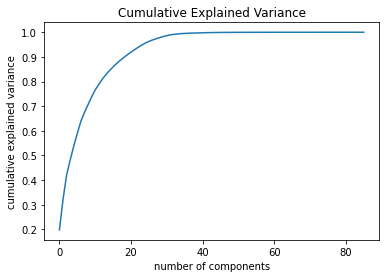

In [10]:
#PCA to minimize multicollinearity
pca = PCA().fit(X_train)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.title('Cumulative Explained Variance')
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')

In [11]:
#apply dimensionality reduction to data, keeping n components
n_components = 30
pca=PCA(n_components=n_components)

X_train = pd.DataFrame(pca.fit_transform(X_train))

## Model Implementation

In [12]:
#implement linear regression

lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

print('Train COD: ', lin_reg.score(X_train, y_train))

Train COD:  0.17028798424347125


In [13]:
#implement baseline random forest
rf = RandomForestRegressor()
rf.fit(X_train, y_train)

print('Train COD: ', rf.score(X_train, y_train))

Train COD:  0.8798151713186412


In [14]:
from IPython.display import clear_output
#tune random forest

n_estimators = [int(x) for x in np.linspace(start=100, stop=250, num=10)]
max_features = ['sqrt', 'log2', None]
#max_depth = [int(x) for x in np.linspace(10,110, num=11)]
max_depth = [int(x) for x in np.linspace(3, 30, num=10)]
min_samples_leaf = [1, 2, 4, 6]
bootstrap = [True, False]

random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
rf = RandomForestRegressor()
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=3, verbose=10)
rf_random.fit(X_train, y_train)
clear_output()


In [15]:
import pickle

rf_tuned = rf_random.best_estimator_
print('Tuned Train COD: ', rf_tuned.score(X_train, y_train))
print('Best Params: ', rf_random.best_params_)
pickle.dump(rf_tuned, open('rf.pkl', 'wb'))

Tuned Train COD:  0.31935644990624545
Best Params:  {'n_estimators': 133, 'min_samples_leaf': 6, 'max_features': None, 'max_depth': 9, 'bootstrap': True}


## Model Evaluation

In [16]:
#import betting spreads data
book_spreads_df = pd.read_csv('spreads_df.csv')
book_spreads_df.drop(columns=['Unnamed: 0'], inplace=True)
book_spreads_df.head()

,GM_DATE,HOME_TEAM,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,2021-10-19,Milwaukee,+1½,-110,+2,-113,+2,-113,+2½,-135,-1½,-110,-2,-108,-2,-108,-2½,-105
1,2021-10-19,L.A. Lakers,+3,-110,+3,-112,+3,-112,+4,-135,-3,-110,-3,-109,-3,-109,-4,-105
2,2021-10-20,Charlotte,-1,+100,+½,-110,+1½,-110,-1½,-110,+1,-120,-½,-110,-1½,-112,+1½,-110
3,2021-10-20,Detroit,-5,-110,-5,-112,-5,-112,-5,-110,+5,-110,+5,-110,+5,-110,+5,-110
4,2021-10-20,Toronto,+2½,-110,+2½,-109,+3,-109,+4½,-160,-2½,-110,-2½,-112,-3,-112,-4½,+115


In [17]:
#create lookup for team id and team city
team_id_city_lookup = {}
for i, row in test_df.iterrows():
    team_id = row['TEAM_ID_HOME']
    team_city = row['TEAM_CITY_HOME']
    if team_id not in team_id_city_lookup:
        team_id_city_lookup[team_id] = [team_city]
    elif team_city not in team_id_city_lookup[team_id]:
        team_id_city_lookup[team_id].append(team_city)
team_id_city_lookup

{1610612739: ['Cleveland'],
 1610612744: ['Golden State'],
 1610612765: ['Detroit'],
 1610612754: ['Indiana'],
 1610612753: ['Orlando'],
 1610612764: ['Washington'],
 1610612738: ['Boston'],
 1610612763: ['Memphis'],
 1610612742: ['Dallas'],
 1610612762: ['Utah'],
 1610612759: ['San Antonio'],
 1610612756: ['Phoenix'],
 1610612758: ['Sacramento'],
 1610612761: ['Toronto'],
 1610612760: ['Oklahoma City'],
 1610612747: ['Los Angeles'],
 1610612766: ['Charlotte'],
 1610612755: ['Philadelphia'],
 1610612749: ['Milwaukee'],
 1610612751: ['Brooklyn'],
 1610612750: ['Minnesota'],
 1610612740: ['New Orleans'],
 1610612748: ['Miami'],
 1610612752: ['New York'],
 1610612741: ['Chicago'],
 1610612745: ['Houston'],
 1610612743: ['Denver'],
 1610612746: ['LA'],
 1610612757: ['Portland'],
 1610612737: ['Atlanta']}

In [18]:
#clean up lookup table to align team ids with team city names from sportsbooks
team_id_city_lookup[1610612747] = ['L.A. Lakers']
team_id_city_lookup[1610612746] = ['L.A. Clippers']
team_id_city_lookup[1610612760] = ['Oklahoma City']
team_id_city_lookup[1610612751] = ['Brooklyn']
team_id_city_lookup[1610612763] = ['Memphis']
team_id_city_lookup[1610612740] = ['New Orleans']

team_city_id_lookup = {}

for key, val in team_id_city_lookup.items():
    team_city_id_lookup[val[0]] = key

team_city_id_lookup

{'Cleveland': 1610612739,
 'Golden State': 1610612744,
 'Detroit': 1610612765,
 'Indiana': 1610612754,
 'Orlando': 1610612753,
 'Washington': 1610612764,
 'Boston': 1610612738,
 'Memphis': 1610612763,
 'Dallas': 1610612742,
 'Utah': 1610612762,
 'San Antonio': 1610612759,
 'Phoenix': 1610612756,
 'Sacramento': 1610612758,
 'Toronto': 1610612761,
 'Oklahoma City': 1610612760,
 'L.A. Lakers': 1610612747,
 'Charlotte': 1610612766,
 'Philadelphia': 1610612755,
 'Milwaukee': 1610612749,
 'Brooklyn': 1610612751,
 'Minnesota': 1610612750,
 'New Orleans': 1610612740,
 'Miami': 1610612748,
 'New York': 1610612752,
 'Chicago': 1610612741,
 'Houston': 1610612745,
 'Denver': 1610612743,
 'L.A. Clippers': 1610612746,
 'Portland': 1610612757,
 'Atlanta': 1610612737}

In [19]:
#add team ids to sportsbook df
book_spreads_df['TEAM_ID_HOME'] = book_spreads_df.apply(lambda row: team_city_id_lookup[row['HOME_TEAM']], axis=1)

#merge test_df and sportsbook data
book_spreads_df.rename(columns={'GM_DATE':'GAME_DATE'}, inplace=True)
test_df['GAME_DATE'] = pd.to_datetime(test_df['GAME_DATE'])
book_spreads_df['GAME_DATE'] = pd.to_datetime(book_spreads_df['GAME_DATE'])
test_df = test_df.merge(book_spreads_df, on=['GAME_DATE', 'TEAM_ID_HOME'], how='inner')
test_df.head()

,TEAM_ID_HOME,GAME_DATE,FGM_HOME,FGA_HOME,FG_PCT_HOME,FG3M_HOME,FG3A_HOME,FG3_PCT_HOME,FTM_HOME,FTA_HOME,...,SPREAD_4_AWAY,ODDS_4_AWAY,SPREAD_1_HOME,ODDS_1_HOME,SPREAD_2_HOME,ODDS_2_HOME,SPREAD_3_HOME,ODDS_3_HOME,SPREAD_4_HOME,ODDS_4_HOME
0,1610612739,2017-10-17,40.965110,83.948117,0.489223,13.676423,34.233172,0.398315,18.124519,23.845221,...,NaN,-,-4½,-110,-12½,+270,NaN,-,NaN,-
1,1610612744,2017-10-17,42.786234,86.941411,0.493566,12.430904,32.432811,0.384523,18.696132,23.329725,...,NaN,-,-9½,-105,-2½,-345,NaN,-,NaN,-
2,1610612765,2017-10-18,40.381062,91.404003,0.442620,7.880397,24.430698,0.318337,13.335979,19.243777,...,NaN,-,-3,-110,+4½,-250,NaN,-,NaN,-
3,1610612754,2017-10-18,39.926003,85.017516,0.470463,9.567652,24.508514,0.387135,16.889065,21.116228,...,NaN,-,-3,-110,+5½,-305,NaN,-,NaN,-
4,1610612753,2017-10-18,38.876910,88.284417,0.440425,8.685238,26.505495,0.326234,17.322239,21.988664,...,NaN,-,+3½,-110,+9½,-250,NaN,-,NaN,-


In [20]:
#convert fractional betting spread strings into floats

def convert_to_float(frac_str):
    try:
        return float(frac_str)
    except ValueError:
        output = frac_str[:-1]
        
        if output=='+':
            return 0.5
        elif output=='-':
            return -0.5
        
        if output[0]=='-':
            output = float(output) - 0.5
        elif output[0]=='+':
            output = float(output) + 0.5
        return output

In [21]:
#isolate book spreads
book_spreads = test_df[['SPREAD_1_AWAY',
                        'ODDS_1_AWAY',
                        'SPREAD_2_AWAY',
                        'ODDS_2_AWAY',
                        'SPREAD_3_AWAY',
                        'ODDS_3_AWAY',
                        'SPREAD_4_AWAY',
                        'ODDS_4_AWAY']].copy()

#convert fraction spreads to floats
book_spreads['SPREAD_1_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_1_AWAY']), axis=1)
book_spreads['SPREAD_2_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_2_AWAY']), axis=1)
book_spreads['SPREAD_3_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_3_AWAY']), axis=1)
book_spreads['SPREAD_4_AWAY'] = book_spreads.apply(lambda row: convert_to_float(row['SPREAD_4_AWAY']), axis=1)

book_spreads.head()

,SPREAD_1_AWAY,ODDS_1_AWAY,SPREAD_2_AWAY,ODDS_2_AWAY,SPREAD_3_AWAY,ODDS_3_AWAY,SPREAD_4_AWAY,ODDS_4_AWAY
0,4.5,-110,12.5,-345,NaN,-,NaN,-
1,9.5,-115,2.5,+270,NaN,-,NaN,-
2,3.0,-110,-5.5,+240,NaN,-,NaN,-
3,3.0,-110,-5.5,+240,NaN,-,NaN,-
4,-3.5,-110,-11.5,+260,NaN,-,NaN,-


In [22]:
#process testing data

#isolate target variable and drop unnecessary non-feature columns
y_test = test_df['GAME_SPREAD'].copy()
X_test = test_df.drop(columns=['GAME_SPREAD', 
                               'TEAM_CITY_HOME', 
                               'TEAM_CITY_AWAY', 
                               'TEAM_ID_HOME', 
                               'GAME_DATE',
                               'HOME_TEAM',
                               'SPREAD_1_AWAY',
                               'ODDS_1_AWAY',
                               'SPREAD_2_AWAY',
                               'ODDS_2_AWAY',
                               'SPREAD_3_AWAY',
                               'ODDS_3_AWAY',
                               'SPREAD_4_AWAY',
                               'ODDS_4_AWAY',
                               'SPREAD_1_HOME',
                               'ODDS_1_HOME',
                               'SPREAD_2_HOME',
                               'ODDS_2_HOME',
                               'SPREAD_3_HOME',
                               'ODDS_3_HOME',
                               'SPREAD_4_HOME',
                               'ODDS_4_HOME']).copy()

#standardize
X_test[list(X_test.columns)] = sclr.transform(X_test)

#pca
X_test = pd.DataFrame(pca.transform(X_test))

In [23]:
#define evaluation funtion
def evaluate_model(model):
    
    #get predicted spreads
    preds = model.predict(X_test)
    print('Train COD: ', model.score(X_train, y_train))
    print('Test COD: ', model.score(X_test, y_test))
    
    count_correct = 0
    for i, pred_spread in enumerate(preds):
        book_1_spread = book_spreads.iloc[i,0]
        actual_spread = y_test.iloc[i]
        if (actual_spread < book_1_spread and pred_spread < book_1_spread) or (actual_spread > book_1_spread and pred_spread > book_1_spread):
            count_correct += 1
            
    print('Win Percentage: ', count_correct/len(preds))

In [24]:
evaluate_model(lin_reg)

Train COD:  0.17028798424347125
Test COD:  0.14570781903401153
Win Percentage:  0.46479550922213314


In [28]:
rf.fit(X_train, y_train)
evaluate_model(rf)


Train COD:  0.8799651346553522
Test COD:  0.11366211022704154
Win Percentage:  0.46800320769847636


In [26]:
evaluate_model(rf_tuned)

Train COD:  0.31935644990624545
Test COD:  0.13226970944446725
Win Percentage:  0.4657578187650361
